Draw a confusion matrix for the trained model

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from transformers import ResNetForImageClassification, AutoImageProcessor
from datasets import load_dataset
import torch
from torchvision import transforms
from consts import TRAIN_TEST_IMAGES_DIR

# Load the trained model
model = ResNetForImageClassification.from_pretrained("./font-identifier/")
model.eval() # Set model to evaluation mode

# Load the test data and apply the same transformations
dataset = load_dataset("imagefolder", data_dir=TRAIN_TEST_IMAGES_DIR)
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-18")

img_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Convert images to grayscale with 3 channels
    transforms.RandomCrop((224, 224)), # Resize images to the expected input size of the model
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet stats
])

# Transform function (make sure it's the same as used in training)
def do_transforms(examples):
    examples["pixel_values"] = [img_transforms(image.convert("RGB")) for image in examples["image"]]
    del examples["image"]
    return examples

dataset.set_transform(do_transforms)

# Prepare DataLoader
test_loader = torch.utils.data.DataLoader(dataset['test'], batch_size=16)

# Make predictions
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['pixel_values'].to(model.device)
        labels = batch['label'].to(model.device)
        outputs = model(inputs)
        _, preds = torch.max(outputs.logits, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


Resolving data files:   0%|          | 0/1960 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/490 [00:00<?, ?it/s]

Found cached dataset imagefolder (/Users/gabor/.cache/huggingface/datasets/imagefolder/default-1d2ed81eaf162a4f/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/2 [00:00<?, ?it/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


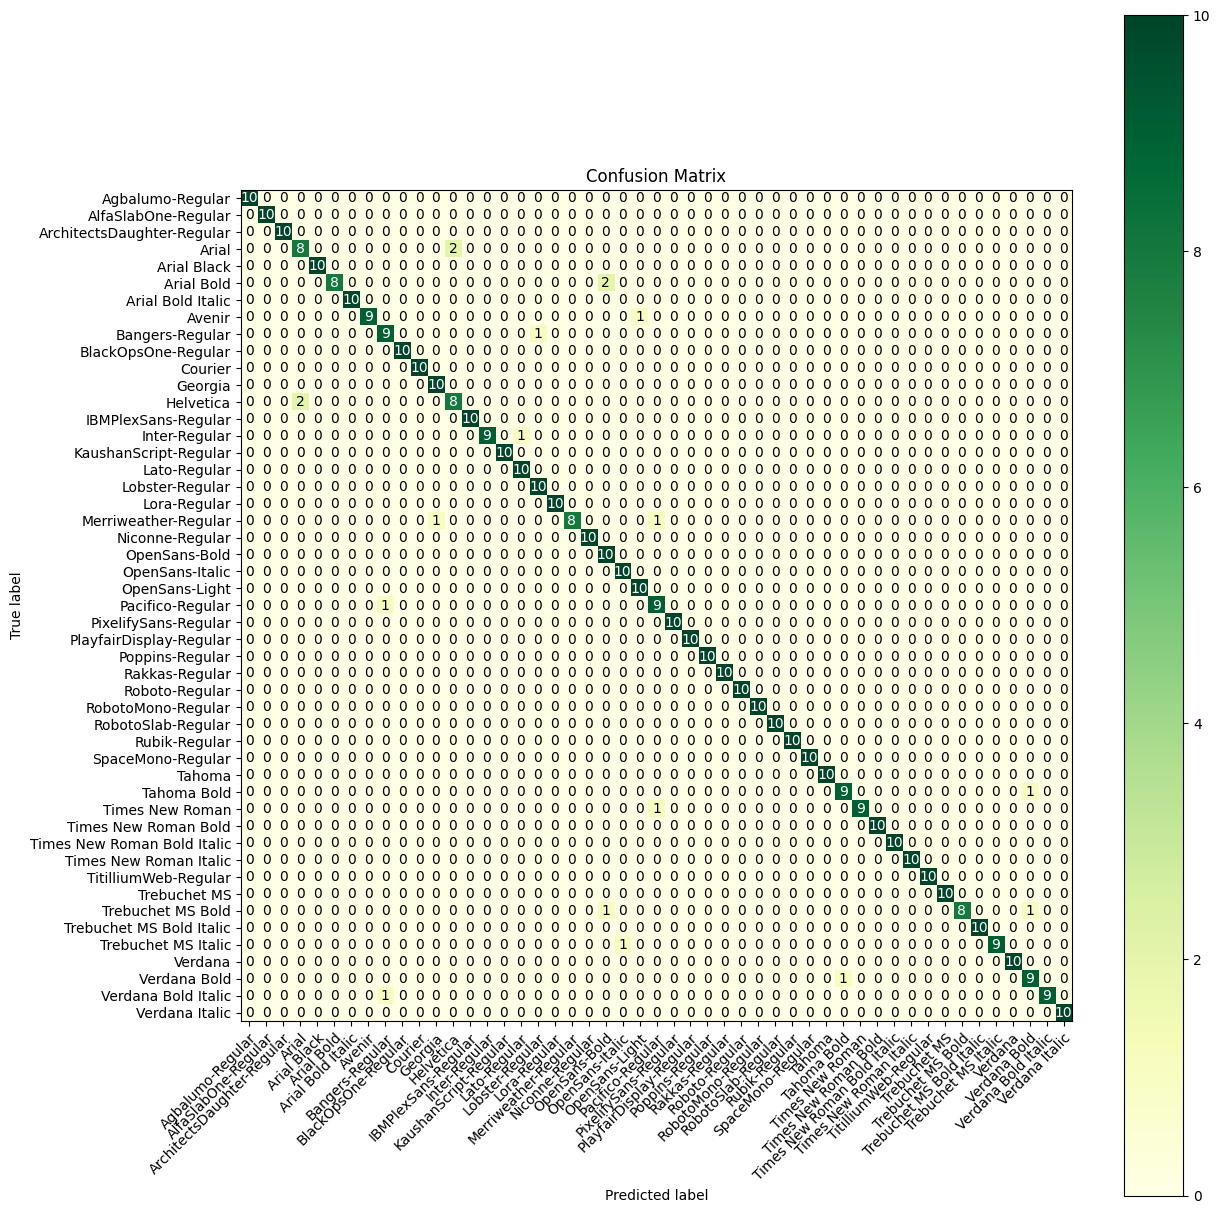

In [9]:
# Plot Confusion Matrix
def plot_confusion_matrix(labels, predictions, class_names):
    cm = confusion_matrix(labels, predictions)
    fig, ax = plt.subplots(figsize=(13, 13))
    im = ax.imshow(cm, interpolation='nearest', cmap='YlGn') # Red-Yellow-Green colormap
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(all_labels, all_preds, class_names=dataset['test'].features['label'].names)
plt.show()
